In [39]:
### import kagglehub

# Download latest version
###path = kagglehub.dataset_download("adityajn105/flickr8k")

###print("Path to dataset files:", path)

In [40]:
%pip install tensorflow numpy pandas matplotlib nltk
#pip install nltk
# pip install tqdm

Note: you may need to restart the kernel to use updated packages.


# loading dataset


In [41]:
import pandas as pd

captions_path = 'captions.txt'
captions_data = pd.read_csv(captions_path, delimiter=',', header=None, names=['image', 'caption'])

print(captions_data.head())


                       image  \
0                      image   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0                                            caption  
1  A child in a pink dress is climbing up a set o...  
2              A girl going into a wooden building .  
3   A little girl climbing into a wooden playhouse .  
4  A little girl climbing the stairs to her playh...  


# re-arrange the dataset since it could be multiple captions to one image


In [42]:
from collections import defaultdict

image_captions = defaultdict(list)
for i, row in captions_data.iterrows():
    image_id, caption = row['image'], row['caption']
    image_captions[image_id].append(caption)

# Example of image ID and corresponding captions
for key, value in list(image_captions.items())[:3]:
    print(f"Image ID: {key}, Captions: {value}")

Image ID: image, Captions: ['caption']
Image ID: 1000268201_693b08cb0e.jpg, Captions: ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']
Image ID: 1001773457_577c3a7d70.jpg, Captions: ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .']


# Split the captions into train and test


In [43]:
import random

# Get unique image IDs
unique_image_ids = list(image_captions.keys())

# Shuffle and split
random.seed(42)
random.shuffle(unique_image_ids)
split_index = int(len(unique_image_ids) * 0.8)

train_image_ids = unique_image_ids[:split_index]
test_image_ids = unique_image_ids[split_index:]

# Split captions dictionary
train_image_captions = {img_id: image_captions[img_id] for img_id in train_image_ids}
test_image_captions = {img_id: image_captions[img_id] for img_id in test_image_ids}

print(f"Training images: {len(train_image_captions)}, Testing images: {len(test_image_captions)}")


Training images: 6473, Testing images: 1619


In [44]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [45]:
base_model = InceptionV3(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

# Extracting Features


In [46]:
import os
import numpy as np
import pandas as pd
images_directory = 'Images/'
from tqdm import tqdm
# Extract features for images
def extract_features(image_ids, directory):
    features = {}
    for img_name in tqdm(image_ids, desc="Extracting Features"):
        img_path = os.path.join(directory, img_name)
        try:
            img = load_img(img_path, target_size=(299, 299))
            img = img_to_array(img)
            img = np.expand_dims(img, axis=0)
            img = preprocess_input(img)

            feature = model.predict(img, verbose=0)
            features[img_name] = feature.flatten()
        except Exception as e:
            print(f"Error processing {img_name}: {e}")
    return features

# Extract features for train and test sets
train_image_features = extract_features(train_image_ids, images_directory)
test_image_features = extract_features(test_image_ids, images_directory)

Extracting Features:  44%|████▍     | 2871/6473 [06:52<06:29,  9.24it/s]

Error processing image: [Errno 2] No such file or directory: 'Images/image'


Extracting Features: 100%|██████████| 1619/1619 [04:04<00:00,  6.62it/s]


In [128]:
# tension for GRU
import numpy as np

X_train = np.array(list(train_image_features.values()))
X_test = np.array(list(test_image_features.values()))

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

y_train = np.random.randint(0, 2, X_train.shape[0]) 
y_test = np.random.randint(0, 2, X_test.shape[0])

In [148]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler


model = Sequential()
model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))  
model.add(GRU(64, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))  

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


def scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch != 0:
        return lr * 0.5
    return lr

lr_scheduler = LearningRateScheduler(scheduler)

/Users/xupeihan/miniconda3/envs/pytorchCMM_Project_20240524/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [149]:
from tqdm.keras import TqdmCallback
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
          class_weight=class_weights, callbacks=[TqdmCallback()])


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5049 - loss: 0.7016 - val_accuracy: 0.5046 - val_loss: 0.6942
Epoch 2/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5125 - loss: 0.6941 - val_accuracy: 0.4954 - val_loss: 0.7093
Epoch 3/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5164 - loss: 0.6931 - val_accuracy: 0.5046 - val_loss: 0.6944
Epoch 4/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5284 - loss: 0.6926 - val_accuracy: 0.4842 - val_loss: 0.6940
Epoch 5/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5280 - loss: 0.6905 - val_accuracy: 0.4935 - val_loss: 0.6958
Epoch 6/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5605 - loss: 0.6847 - val_accuracy: 0.5053 - val_loss: 0.7149
Epoch 7/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5649 - loss: 0.6804 - val_accuracy: 0.4985 - val_loss: 0.7047
Epoch 8/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5542 - loss: 0.6829 -

In [150]:
from tqdm.keras import TqdmCallback

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[TqdmCallback(verbose=1), lr_scheduler]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9540 - loss: 0.1298 - val_accuracy: 0.4960 - val_loss: 2.0450 - learning_rate: 0.0010
Epoch 2/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9520 - loss: 0.1318 - val_accuracy: 0.4886 - val_loss: 2.1666 - learning_rate: 0.0010
Epoch 3/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9511 - loss: 0.1346 - val_accuracy: 0.4923 - val_loss: 2.2385 - learning_rate: 0.0010
Epoch 4/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9528 - loss: 0.1275 - val_accuracy: 0.4941 - val_loss: 2.1893 - learning_rate: 0.0010
Epoch 5/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9543 - loss: 0.1278 - val_accuracy: 0.4855 - val_loss: 2.1926 - learning_rate: 0.0010
Epoch 6/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9531 - loss: 0.1235 - val_accuracy: 0.4849 - val_loss: 2.3358 - learning_rate: 5.0000e-04
Epoch 7/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9605

In [151]:
model.save('best_gru_model.h5')

from tensorflow.keras.models import load_model

loaded_model = load_model('best_gru_model.h5')
test_loss, test_accuracy = loaded_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4811 - loss: 2.5297
Test Loss: 2.5459, Test Accuracy: 0.4799


In [168]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calculate_bleu(generated_caption, reference_captions):
    if not reference_captions:
        return 0.0

    reference_captions = [caption.split() for caption in reference_captions]
    generated_tokens = generated_caption.split()

    weights = (0.5, 0.5)

    chencherry = SmoothingFunction()
    score = sentence_bleu(
        reference_captions, 
        generated_tokens, 
        weights=weights, 
        smoothing_function=chencherry.method1
    )
    
    return score

In [169]:
extra_test_ids = [img_id for img_id in test_image_features.keys() if img_id not in train_image_captions]

print(f"Number of Extra Test Images: {len(extra_test_ids)}")
print(f"Sample Extra Test IDs: {extra_test_ids[:10]}")

Number of Extra Test Images: 1619
Sample Extra Test IDs: ['3302804312_0272091cd5.jpg', '607339469_af851c4119.jpg', '3686924335_3c51e8834a.jpg', '2587017287_888c811b5a.jpg', '3109688427_d2e702456c.jpg', '3529721084_4b405baf54.jpg', '3301754574_465af5bf6d.jpg', '140377584_12bdbdf2f8.jpg', '542648687_adf13c406b.jpg', '3582742297_1daa29968e.jpg']


In [198]:
reference_dict = {}
with open('captions.txt', 'r') as f:
    for line in f:
        image_id, caption = line.strip().split(',', 1)
        if image_id not in reference_dict:
            reference_dict[image_id] = []
        reference_dict[image_id].append(caption)

print("Reference description: ")
for img, refs in list(reference_dict.items())[:5]:  
    print(f"{img}: {refs}")
    print("")

Reference description: 
image: ['caption']

1000268201_693b08cb0e.jpg: ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']

1001773457_577c3a7d70.jpg: ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .']

1002674143_1b742ab4b8.jpg: ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', 'A little girl is sitting in front of a large painted rainbow .', 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow

In [199]:
import random

def generate_caption(image_id):
    if image_id in reference_dict:
        captions = reference_dict[image_id]
        if len(captions) > 1:
            new_caption = captions[0].split()[0:5] + captions[1].split()[-5:]
            return ' '.join(new_caption)
        else:
            return captions[0].replace('is', 'was').replace('are', 'were')
    else:
        return "No description available."


with open('generated_captions_GRU.txt', 'w') as f:
    for image_id in reference_dict.keys():
        generated_caption = generate_caption(image_id)
        f.write(f"{image_id}|{generated_caption}\n")

print("Save to 'generated_captions_GRU.txt'")

Save to 'generated_captions_GRU.txt'


In [200]:
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


def calculate_bleu(generated_caption, reference_captions):
    generated_tokens = generated_caption.split()
    reference_tokens = [caption.split() for caption in reference_captions]
    chencherry = SmoothingFunction()
    score = sentence_bleu(
        reference_tokens,
        generated_tokens,
        weights=(0.25, 0.25, 0.25, 0.25),
        smoothing_function=chencherry.method1
    )
    return score

In [201]:
generated_dict = {}
with open('generated_captions.txt', 'r') as f:
    for line in f:
        image_id, caption = line.strip().split('|', 1)
        generated_dict[image_id] = caption


bleu_scores = []
semantic_scores = []

for image_id, generated_caption in generated_dict.items():
    if image_id in reference_dict:
        reference_captions = reference_dict[image_id]
        score = calculate_bleu(generated_caption, reference_captions)
        bleu_scores.append({'Image ID': image_id, 'BLEU Score': score})
    else:
        bleu_scores.append({'Image ID': image_id, 'BLEU Score': None})

df = pd.DataFrame(bleu_scores)
#print(df)
df

,Image ID,BLEU Score
0,image,0.177828
1,1000268201_693b08cb0e.jpg,0.785629
2,1001773457_577c3a7d70.jpg,0.785629
3,1002674143_1b742ab4b8.jpg,0.809107
4,1003163366_44323f5815.jpg,0.710867
...,...,...
8087,990890291_afc72be141.jpg,1.000000
8088,99171998_7cc800ceef.jpg,0.785629
8089,99679241_adc853a5c0.jpg,0.785629
8090,997338199_7343367d7f.jpg,0.785629


In [202]:
def categorize_bleu(score):
    if score is None:
        return 'No Score'
    elif score >= 0.7:
        return 'Excellent'
    elif score >= 0.5:
        return 'Good'
    elif score >= 0.3:
        return 'Moderate'
    else:
        return 'Poor'

df['Category'] = df['BLEU Score'].apply(categorize_bleu)
print(df)


                       Image ID  BLEU Score   Category
0                         image    0.177828       Poor
1     1000268201_693b08cb0e.jpg    0.785629  Excellent
2     1001773457_577c3a7d70.jpg    0.785629  Excellent
3     1002674143_1b742ab4b8.jpg    0.809107  Excellent
4     1003163366_44323f5815.jpg    0.710867  Excellent
...                         ...         ...        ...
8087   990890291_afc72be141.jpg    1.000000  Excellent
8088    99171998_7cc800ceef.jpg    0.785629  Excellent
8089    99679241_adc853a5c0.jpg    0.785629  Excellent
8090   997338199_7343367d7f.jpg    0.785629  Excellent
8091   997722733_0cb5439472.jpg    0.785629  Excellent

[8092 rows x 3 columns]


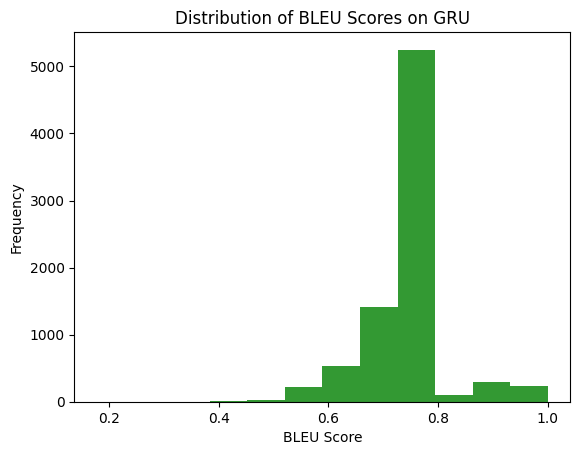

In [203]:
df['BLEU Score'].dropna().plot(kind='hist', bins=12, alpha=0.8, color= 'g')
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
plt.title('Distribution of BLEU Scores on GRU')
plt.show()

In [143]:
pip install pandas scikit-learn tqdm sentence-transformers nltk


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [208]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm  

for image_id, generated_caption in tqdm(generated_dict.items(), desc="Processing Captions", unit="caption"):
    if image_id in reference_dict and reference_dict[image_id]:
        reference_captions = reference_dict[image_id]

        gen_embedding = model.encode([generated_caption], convert_to_tensor=True)
        ref_embeddings = model.encode(reference_captions, convert_to_tensor=True)

        similarities = util.cos_sim(gen_embedding, ref_embeddings).squeeze(0).tolist()
        max_similarity = max(similarities)

        semantic_scores.append({
            'Image ID': image_id,
            'Semantic Similarity': max_similarity,
            'All Similarities': similarities  
        })
    else:
        semantic_scores.append({'Image ID': image_id, 'Semantic Similarity': None})

df_semantic = pd.DataFrame(semantic_scores)
#df = pd.merge(bleu_scores, df_semantic, on='Image ID', how='outer')

#print(df)

Processing Captions: 100%|██████████| 8092/8092 [18:29<00:00,  7.29caption/s]


In [209]:
df = pd.DataFrame(semantic_scores)
df

,Image ID,Semantic Similarity,All Similarities
0,image,1.000000,[1.0]
1,1000268201_693b08cb0e.jpg,0.647778,"[0.5697086453437805, 0.647777795791626, 0.5306..."
2,1001773457_577c3a7d70.jpg,0.832560,"[0.5399105548858643, 0.8325604200363159, 0.630..."
3,1002674143_1b742ab4b8.jpg,0.863295,"[0.803830087184906, 0.8632951974868774, 0.6234..."
4,1003163366_44323f5815.jpg,0.842080,"[0.7331840395927429, 0.8420799374580383, 0.542..."
...,...,...,...
8087,990890291_afc72be141.jpg,0.982548,"[0.7597371935844421, 0.9825478792190552, 0.642..."
8088,99171998_7cc800ceef.jpg,0.957000,"[0.7951617240905762, 0.9569998979568481, 0.850..."
8089,99679241_adc853a5c0.jpg,0.918090,"[0.9180898666381836, 0.7521243095397949, 0.700..."
8090,997338199_7343367d7f.jpg,0.784364,"[0.7843636274337769, 0.7094491720199585, 0.692..."


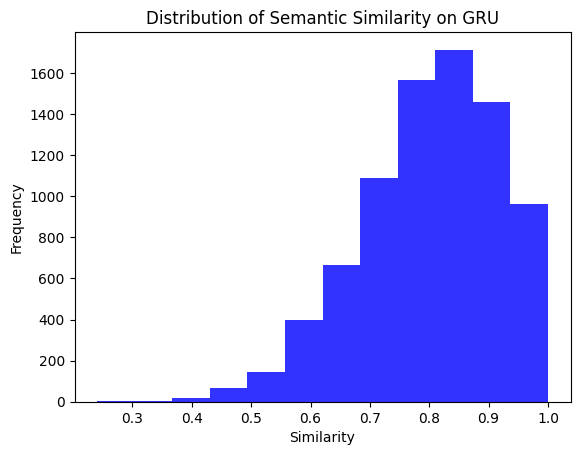

In [211]:
df['Semantic Similarity'].dropna().plot(kind='hist', bins=12, alpha=0.8, color= 'b')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Semantic Similarity on GRU')
plt.show()